# ASPIRE ab initio pipeline -- simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.proposals import CryoProposals
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.projection import project

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from aspire.abinitio import CLSyncVoting
from aspire.basis import FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)


### Parameters

In [3]:
interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 1000  # How many images in our source.
n_classes = 100  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
noise_variance = 5e-7  # Set a target noise variance
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True


### Simulation data

In [4]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"

og_v = Volume.load(vol_file, dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

2022-06-17 17:57:20,748 INFO /home/bt387/project/simple_cryoem/data/emdb/emd_2660.map with dtype float32 loaded as <class 'numpy.float64'>
2022-06-17 17:57:20,860 INFO Original volume map data shape: (1, 360, 360, 360) dtype:float64


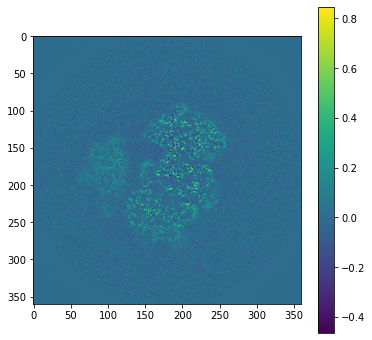

In [5]:
plt.imshow(og_v[0,180]); plt.colorbar()

In [6]:
logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution

2022-06-17 17:57:21,103 INFO Downsampling to (32, 32, 32)


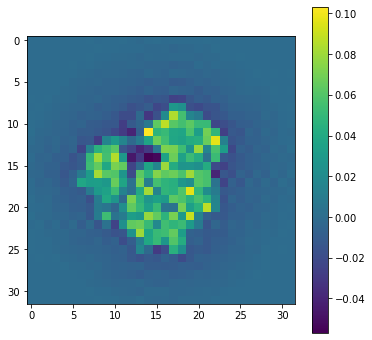

In [7]:
plt.imshow(v[0,16]); plt.colorbar()

In [8]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v.mrc', overwrite=True) as mrc:
        mrc.set_data(og_v._data.astype(np.float32))

In [9]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

In [10]:
# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise_filter = FunctionFilter(noise_function)

In [11]:
logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]



2022-06-17 17:57:29,695 INFO Initialize CTF filters.


2022-06-17 17:57:38,533 INFO Creating Simulation with 1000 images.
2022-06-17 17:57:38,535 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 17:57:38,551 INFO Creating Simulation with 1000 images.
2022-06-17 17:57:38,552 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 17:57:38,562 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:57:38,564 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:57:38,565 INFO Trying NFFT backend finufft
2022-06-17 17:57:38,572 INFO NFFT backend finufft usable.
2022-06-17 17:57:38,573 INFO Trying NFFT backend cufinufft
2022-06-17 17:57:38,574 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2022-06-17 17:57:38,575 INFO Trying NFFT backend pynfft
2022-06-17 17:57:38,576 INFO NFFT bac

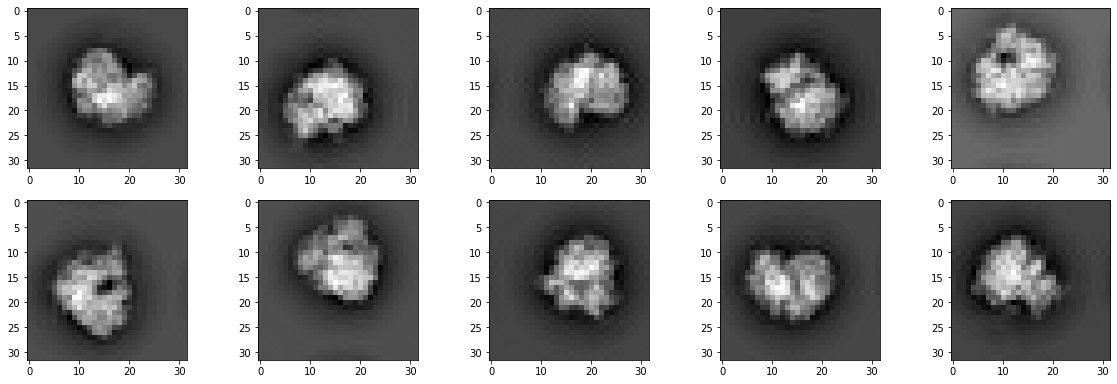

In [13]:
# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)

angles = src.angles
shifts = src.offsets

angles[0] = [0,0,0]
shifts[0] = [0,0]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)
# Peek
if interactive:
    src.images(0, 10).show()

In [14]:
# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
#src.phase_flip()


2022-06-17 17:57:41,759 INFO Perform phase flip to input images.


In [15]:
# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
#src.whiten(aiso_noise_estimator.filter)

2022-06-17 17:57:42,096 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:57:42,102 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:57:42,325 INFO Applying forward transformations in pipeline
2022-06-17 17:57:42,326 INFO All forward transformations applied
2022-06-17 17:57:42,327 INFO Loaded 512 images
2022-06-17 17:57:42,334 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:57:42,337 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:57:42,533 INFO Applying forward transformations in pipeline
2022-06-17 17:57:42,534 INFO All forward transformations applied
2022-06-17 17:57:42,534 INFO Loaded 488 images


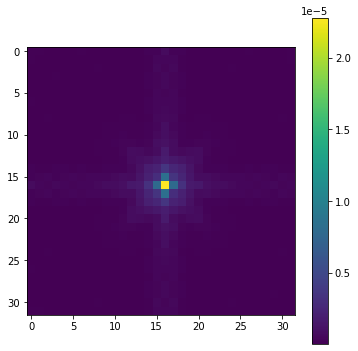

2022-06-17 17:57:42,690 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:57:42,691 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:57:42,721 INFO Applying forward transformations in pipeline
2022-06-17 17:57:42,722 INFO All forward transformations applied
2022-06-17 17:57:42,723 INFO Loaded 10 images


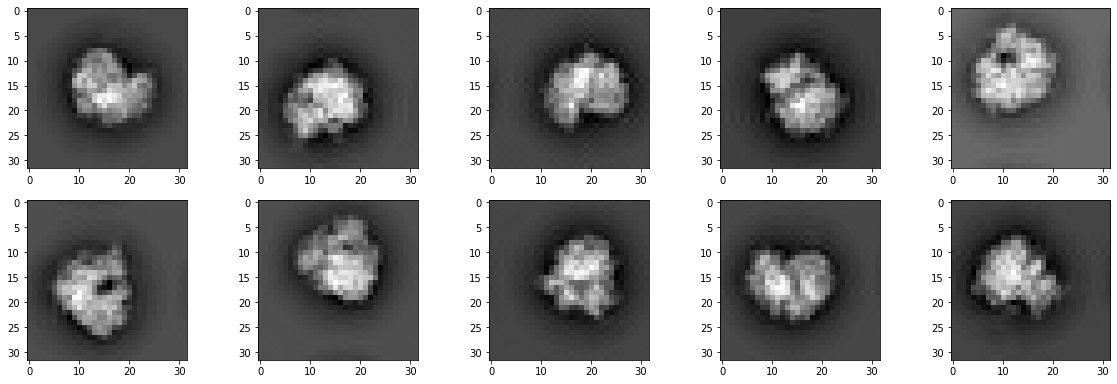

In [16]:
# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.colorbar()
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images(0, 10).show()

In [17]:
# Cache to memory for some speedup
src.cache()

2022-06-17 17:57:43,466 INFO Caching source images
2022-06-17 17:57:43,469 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:57:43,477 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:57:43,859 INFO Applying forward transformations in pipeline
2022-06-17 17:57:43,859 INFO All forward transformations applied
2022-06-17 17:57:43,860 INFO Loaded 1000 images


### Class Averaging

In [ ]:
logging.disable(logging.INFO)

In [ ]:
logger.info("Begin Class Averaging")

rir = RIRClass2D(
    src,  # Source used for classification
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=n_nbor,
    n_classes=n_classes,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    averager=None,
)

classes, reflections, distances = rir.classify()
avgs = rir.averages(classes, reflections, distances)
if interactive:
    avgs.images(0, 10).show()

### Common Line Estimation

In [ ]:
logger.info("Begin Orientation Estimation")

# Stash true rotations for later comparison,
#   note this line only works with naive class selection...
true_rotations = src.rots[:n_classes]

orient_est = CLSyncVoting(avgs, n_theta=36)
# Get the estimated rotations
orient_est.estimate_rotations()
rots_est = orient_est.rotations

logger.info("Compare with known rotations")
# Compare with known true rotations
Q_mat, flag = register_rotations(rots_est, true_rotations)
regrot = get_aligned_rotations(rots_est, Q_mat, flag)
mse_reg = get_rots_mse(regrot, true_rotations)
logger.info(
    f"MSE deviation of the estimated rotations using register_rotations : {mse_reg}\n"
)

### Volume reconstruction

In [ ]:
logger.info("Begin Volume reconstruction")

# Assign the estimated rotations to the class averages
avgs.rots = rots_est

# Create a reasonable Basis for the 3d Volume
basis = FFBBasis3D((v.resolution,) * 3, dtype=v.dtype)

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(avgs, basis)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()
fn = f"estimated_volume_n{num_imgs}_c{n_classes}_m{n_nbor}_{img_size}.mrc"
estimated_volume.save(fn, overwrite=True)

# Peek at result
if interactive:
    plt.imshow(np.sum(estimated_volume[0], axis=-1))
    plt.show()

In [ ]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_aspire.mrc', overwrite=True) as mrc:
        mrc.set_data(estimated_volume._data.astype(np.float32))

### Aspire vs JaxEM

Text(0.5, 1.0, 'Volume_comp MIP')

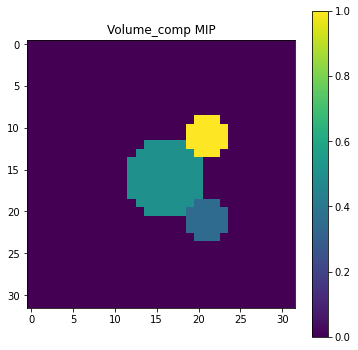

In [19]:
nx = img_size
shape = np.array([nx,nx,nx])
dimensions = pixel_size * shape

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]]) * 500
radii = np.array([0.1, 0.05, 0.05]) * 500
intensities = np.array([10,7,20])

myv = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.1))
mip_z(myv)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

### Compare for specific angles/shifts/ctf_params 

In [20]:
angles[0] = [jnp.pi/6,jnp.pi/4, jnp.pi/2]
shifts[0] = [-5.4, 6.8]

#v._data = np.array([myv])

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()


N = 1
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)
imgs = jnp.array(src.images(0,N).data)
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
shifts = src.offsets

print(f"x_grid = {x_grid}")

2022-06-17 17:58:07,824 INFO Creating Simulation with 1000 images.
2022-06-17 17:58:07,825 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 17:58:07,839 INFO Perform phase flip on source object
2022-06-17 17:58:07,840 INFO Adding Phase Flip Xform to end of generation pipeline
2022-06-17 17:58:08,681 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 17:58:08,684 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 17:58:08,740 INFO Applying forward transformations in pipeline
2022-06-17 17:58:08,741 INFO   Applying IndexedXform
2022-06-17 17:58:08,743 INFO All forward transformations applied
2022-06-17 17:58:08,743 INFO Loaded 1 images
x_grid = [3.07692308e-03 3.20000000e+01]


In [21]:
angles[0]

array([0.5235988, 0.7853982, 1.5707964], dtype=float32)

In [22]:
myshifts = jnp.array([shifts[0,1], shifts[0,0]]) * pixel_size # This seems correct
myangles = -jnp.array([angles[0,2], angles[0,1], angles[0,0]])
myctf_params = jnp.array(
    [jnp.array([f.defocus_u, f.defocus_v, f.defocus_ang, 0, f.voltage, f.alpha, f.Cs, 0, 2*pixel_size]) for f in ctf_filters]
)[0]

Text(0.5, 1.0, 'my projection')

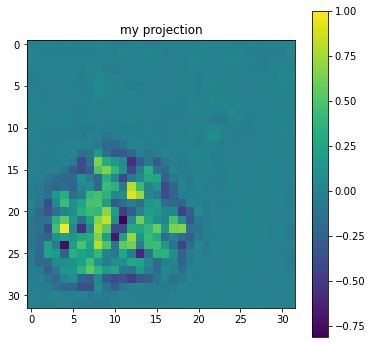

In [23]:
pr = project_spatial(vol, myangles, pixel_size, myshifts, ctf_params= myctf_params)
pr = pr/jnp.max(pr)
plt.imshow(pr); plt.colorbar()
plt.title('my projection')

Text(0.5, 1.0, 'aspire')

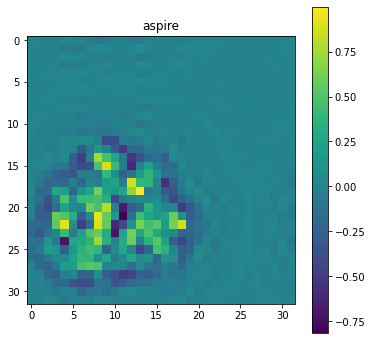

In [24]:
pr_a = imgs[0] /jnp.max(imgs[0])
plt.imshow(pr_a); plt.colorbar()
plt.title('aspire')

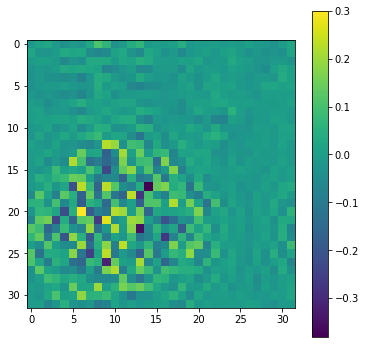

In [25]:
plt.imshow(pr-pr_a); plt.colorbar()

### Compare for many images

In [30]:
def get_params_from_aspire(src: Simulation, N, pixel_size):
    
    imgs = np.array(src.images(0,N).data)
    imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
    
    angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
    shifts = src.offsets
    
    myshifts = jnp.flip(shifts, axis=1) * pixel_size 
    myangles = -jnp.flip(angles, axis=1)
    
    cf = src.unique_filters
    myctf_params = jnp.array(
        [jnp.array([cf[ci].defocus_u, cf[ci].defocus_v, cf[ci].defocus_ang, 0, cf[ci].voltage, cf[ci].alpha, cf[ci].Cs, 0, 2*pixel_size]) for ci in src.filter_indices]
    )
    
    return imgs, imgs_f, myangles, myshifts, myctf_params

@jax.jit
def calc_img_err(img1, img2, mask):
    img1 = jnp.fft.fftshift(img1*mask)
    img1 = img1/jnp.max(jnp.abs(img1))
    
    img2 = jnp.fft.fftshift(img2*mask)
    img2 = img2/jnp.max(jnp.abs(img2))
    
    return jnp.mean(jnp.abs(img1-img2))

calc_img_err_vmap = jax.vmap(calc_img_err, in_axes = (0,0,None))

In [31]:
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()

N = 100
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)

slice_obj = Slice(x_grid)

radius = x_grid[0]*(x_grid[1]/2-1)
mask = create_2d_mask(x_grid, [0,0], radius)

2022-06-17 18:01:30,330 INFO Creating Simulation with 1000 images.
2022-06-17 18:01:30,333 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-17 18:01:30,350 INFO Perform phase flip on source object
2022-06-17 18:01:30,351 INFO Adding Phase Flip Xform to end of generation pipeline


In [32]:
imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params = get_params_from_aspire(src, 1000, pixel_size)
imgs_f = slice_obj.slice_array(vol_f, angles, shifts, ctf_params).reshape([-1, nx,nx])

2022-06-17 18:01:31,152 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-17 18:01:31,161 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-17 18:01:31,574 INFO Applying forward transformations in pipeline
2022-06-17 18:01:31,575 INFO   Applying IndexedXform
2022-06-17 18:01:31,608 INFO All forward transformations applied
2022-06-17 18:01:31,608 INFO Loaded 1000 images


In [33]:
errs = calc_img_err_vmap(imgs_f, imgs_f_aspire, mask)
print(f"errs.shape = {errs.shape}")
print(f"jnp.max(errs) = {jnp.max(errs)}")

errs.shape = (1000,)
jnp.max(errs) = 0.055046765225070605


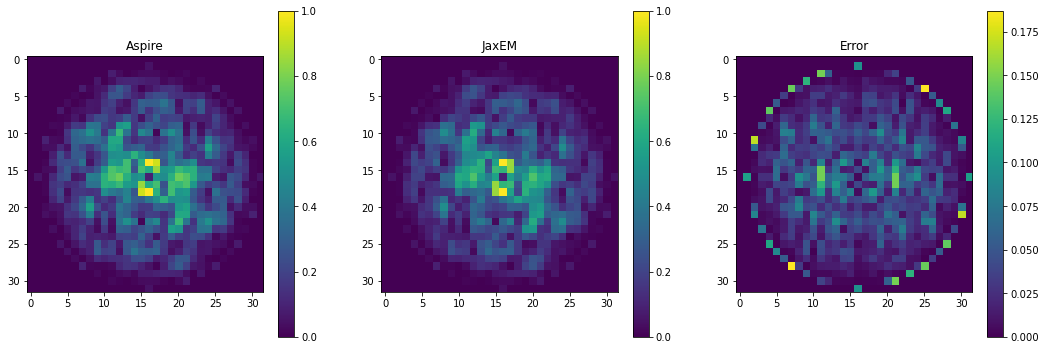

In [34]:
imgidx = 13

img1 = jnp.fft.fftshift(imgs_f_aspire[imgidx]*mask)
img1 = img1/jnp.max(jnp.abs(img1))

img2 = jnp.fft.fftshift(imgs_f[imgidx]*mask)
img2 = img2/jnp.max(jnp.abs(img2))

err_f = jnp.abs(img1-img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(jnp.abs(img1))
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(jnp.abs(img2))
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(err_f)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

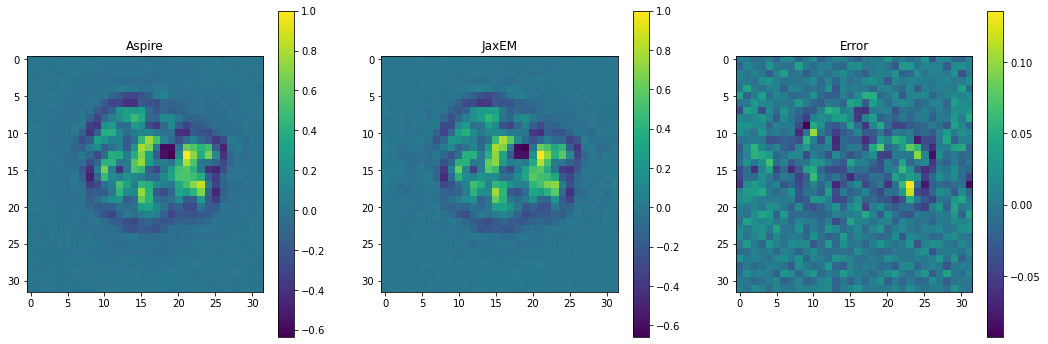

In [35]:
img1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f_aspire[imgidx]*mask)))
img1 = img1/jnp.max(img1)

img2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f[imgidx]*mask)))
img2 = img2/jnp.max(img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(img1)
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(img2)
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(img1-img2)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

### Next: make sure the noise estimation is consistent, and then reconstruct the volume with SGD